<a href="https://colab.research.google.com/github/mot1122/NLP_100_knock/blob/main/chap8_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 第8章: ニューラルネット

第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

### 70 単語ベクトルの和による特徴量

問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．

In [121]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2022-01-25 02:52:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip.1’

NewsAggregatorDatas 100%[===================>]  27.87M  25.2MB/s    in 1.1s    

2022-01-25 02:52:07 (25.2 MB/s) - ‘NewsAggregatorDataset.zip.1’ saved [29224203/29224203]



In [122]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: 2pageSessions.csv       
replace __MACOSX/._2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._2pageSessions.csv  
replace newsCorpora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: newsCorpora.csv         
replace __MACOSX/._newsCorpora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._newsCorpora.csv  
replace readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: readme.txt              
replace __MACOSX/._readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._readme.txt   


In [123]:
!sed -e "s/"\""/'/g" ./newsCorpora.csv > ./newsCorpora_re.csv

In [124]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [125]:
!head -n 3 newsCorpora_re.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550


In [126]:
df=pd.read_csv("./newsCorpora_re.csv",sep="\t",header=None,names=["ID","TITLE","URL","PUBLISHER","CATEGORY","STORY","HOSTNAME","TIMESTAMP"])

In [127]:
df.head(3)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550


In [128]:
df=df.loc[df["PUBLISHER"].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']),["TITLE","CATEGORY"]]

In [129]:
df.head(3)

,TITLE,CATEGORY
12,Europe reaches crunch point on banking union,b
13,ECB FOCUS-Stronger euro drowns out ECB's messa...,b
19,"Euro Anxieties Wane as Bunds Top Treasuries, S...",b


In [130]:
train,valid_test=train_test_split(df,test_size=0.2,shuffle=True,stratify=df["CATEGORY"],random_state=123)
valid,test=train_test_split(valid_test,test_size=0.5,shuffle=True,stratify=valid_test["CATEGORY"],random_state=123)

In [131]:
print("[train]")
print(train["CATEGORY"].value_counts())
print()
print("[valid]")
print(valid["CATEGORY"].value_counts())
print()
print("[test]")
print(test["CATEGORY"].value_counts())


[train]
b    4501
e    4235
t    1220
m     728
Name: CATEGORY, dtype: int64

[valid]
b    563
e    529
t    153
m     91
Name: CATEGORY, dtype: int64

[test]
b    563
e    530
t    152
m     91
Name: CATEGORY, dtype: int64


In [132]:
import gdown
from gensim.models import KeyedVectors

In [133]:
url="https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM"
output='GoogleNews-vectors-negative300.bin.gz'
gdown.download(url,output,quiet=False)

Permission denied: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Maybe you need to change permission over 'Anyone with the link'?


In [134]:
model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz',binary=True)

In [135]:
import string
import torch

In [136]:
def transform_w2v(text):
  table=str.maketrans(string.punctuation," "*len(string.punctuation))
  words=text.translate(table).split()
  vec=[model[word] for word in words if word in model]
  return torch.tensor(sum(vec)/len(vec))

In [137]:
 X_train=torch.stack([transform_w2v(text) for text in train["TITLE"]])
 X_valid=torch.stack([transform_w2v(text) for text in valid["TITLE"]])
 X_test=torch.stack([transform_w2v(text) for text in test["TITLE"]])

In [138]:
print(X_train.size())

torch.Size([10684, 300])


In [139]:
category_dic={"b":0,"t":1,"e":2,"m":3}
y_train=torch.tensor(train["CATEGORY"].map(lambda x:category_dic[x]).values)
y_valid=torch.tensor(valid["CATEGORY"].map(lambda x:category_dic[x]).values)
y_test=torch.tensor(test["CATEGORY"].map(lambda x:category_dic[x]).values)

In [140]:
print(y_train.size())

torch.Size([10684])


In [141]:
torch.save(X_train,"X_train.pt")
torch.save(X_valid,"X_valid.pt")
torch.save(X_test,"X_test.pt")
torch.save(y_train,"y_train.pt")
torch.save(y_valid,"y_valid.pt")
torch.save(y_test,"y_test.pt")

### 71 単層ニューラルネットワークによる予測

>>
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ．
$$\hat{y}=softmax(x_1W),$$
$$\hat{Y}=softmax(X_{[1:4]}W)$$
ただし，$softmax$はソフトマックス関数，$X_{[1:4]}∈ℝ^{4×d}$は特徴ベクトル$x1, x2, x3, x4$を縦に並べた行列である。
$$
X_{[1:4]}=
\begin{pmatrix}
x_1 \\
x_2 \\
x_3 \\
x_4 \\
\end{pmatrix}
$$
行列$W∈ℝ^{d×L}$は単層ニューラルネットワークの重み行列で，ここではランダムな値で初期化すればよい（問題73以降で学習して求める）．

In [142]:
from torch import nn

In [143]:
class SLPNet(nn.Module):
  def __init__(self,input_size,output_size):
    super().__init__()
    self.func=nn.Linear(input_size,output_size,bias=False)
    nn.init.normal_(self.func.weight,0.0,1.0)
  def forward(self,x):
    x=self.func(x)
    return x

In [144]:
model=SLPNet(300,4)
y_hat_1=torch.softmax(model(X_train[:1]),dim=-1)

In [145]:
print(y_hat_1)

tensor([[0.3196, 0.6506, 0.0067, 0.0232]], grad_fn=<SoftmaxBackward0>)


In [146]:
Y_hat=torch.softmax(model(X_train[:4]),dim=-1)

In [147]:
print(Y_hat)

tensor([[0.3196, 0.6506, 0.0067, 0.0232],
        [0.6202, 0.2726, 0.0462, 0.0610],
        [0.8946, 0.0682, 0.0132, 0.0240],
        [0.4108, 0.3855, 0.1692, 0.0345]], grad_fn=<SoftmaxBackward0>)


### 72 損失と勾配の計算
>>
学習データの事例$x1$と事例集合$x1,x2,x3,x4$に対して，クロスエントロピー損失と，行列$W$に対する勾配を計算せよ。

In [148]:
criterion=nn.CrossEntropyLoss()

In [149]:
l_1=criterion(model(X_train[:1]),y_train[:1])

In [150]:
model.zero_grad()

In [151]:
l_1.backward()

In [152]:
print(f"Loss:{l_1:.4f}")
print(f"Grad:\n{model.func.weight.grad}")

Loss:1.1408
Grad:
tensor([[-5.6926e-02, -3.8336e-03, -4.6371e-03,  ..., -5.1118e-02,
         -2.9468e-02,  5.9060e-02],
        [ 5.4432e-02,  3.6657e-03,  4.4339e-03,  ...,  4.8879e-02,
          2.8177e-02, -5.6473e-02],
        [ 5.5697e-04,  3.7509e-05,  4.5370e-05,  ...,  5.0015e-04,
          2.8832e-04, -5.7785e-04],
        [ 1.9368e-03,  1.3043e-04,  1.5776e-04,  ...,  1.7392e-03,
          1.0026e-03, -2.0094e-03]])


In [153]:
l=criterion(model(X_train[:4]),y_train[:4])
model.zero_grad()
l.backward()

In [154]:
print(f"Loss:{l:.4f}")
print(f"Grad:\n{model.func.weight.grad}")

Loss:1.9865
Grad:
tensor([[-0.0028,  0.0047, -0.0269,  ..., -0.0398,  0.0165,  0.0308],
        [ 0.0043,  0.0006,  0.0230,  ...,  0.0292,  0.0218, -0.0129],
        [ 0.0122, -0.0100, -0.0142,  ...,  0.0016, -0.0082,  0.0043],
        [-0.0137,  0.0047,  0.0182,  ...,  0.0090, -0.0301, -0.0222]])


### 73 確率的勾配降下法による学習
>>
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列WWを学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [155]:
from torch.utils.data import Dataset

In [156]:
class NewDataset(Dataset):
  def __init__(self,X,y):
    self.X=X
    self.y=y
  def __len__(self):
    return len(self.y)
  def __getitem__(self,idx):
    return [self.X[idx],self.y[idx]]

In [157]:
from torch.utils.data import DataLoader

In [158]:
dataset_train=NewDataset(X_train,y_train)
dataset_valid=NewDataset(X_valid,y_valid)
dataset_test=NewDataset(X_test,y_test)

dataloader_train=DataLoader(dataset_train,batch_size=1,shuffle=True)
dataloader_valid=DataLoader(dataset_valid,batch_size=len(dataset_valid),shuffle=False)
dataloader_test=DataLoader(dataset_test,batch_size=len(dataset_test),shuffle=False)

In [159]:
model=SLPNet(300,4)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-1)
num_epochs=10
for epoch in range(num_epochs):
  model.train()
  loss_train=0.0
  for i,(inputs,labels) in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    loss_train+=loss.item()
  loss_train=loss_train/i
  model.eval()
  with torch.no_grad():
    inputs,labels=next(iter(dataloader_valid))
    outputs=model(inputs)
    loss_valid=criterion(outputs,labels)
  print(f"epoch:{epoch}, loss_train:{loss_train:.4f}, loss_valid:{loss_valid:.4f}")


epoch:0, loss_train:0.4814, loss_valid:0.3695
epoch:1, loss_train:0.3154, loss_valid:0.3357
epoch:2, loss_train:0.2856, loss_valid:0.3293
epoch:3, loss_train:0.2689, loss_valid:0.3226
epoch:4, loss_train:0.2588, loss_valid:0.3114
epoch:5, loss_train:0.2511, loss_valid:0.3221
epoch:6, loss_train:0.2458, loss_valid:0.3098
epoch:7, loss_train:0.2412, loss_valid:0.3094
epoch:8, loss_train:0.2370, loss_valid:0.3095
epoch:9, loss_train:0.2343, loss_valid:0.3097


### 74 正解率の計測
>>
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [160]:
def calculate_accuracy(model,loader):
  model.eval()
  counts,total=0,0
  with torch.no_grad():
    for inputs,labels in loader:
      outputs=model(inputs)
      pred=torch.argmax(outputs,dim=-1)
      total+=len(labels)
      counts+=(pred==labels).sum().item()
  return counts/total

In [161]:
acc_train=calculate_accuracy(model,dataloader_train)
acc_test=calculate_accuracy(model, dataloader_test)
print(f"accuracy train:{acc_train:.4f}")
print(f"accuracy test:{acc_test:.4f}")

accuracy train:0.9256
accuracy test:0.8990


### 75 損失と正解率のプロット
>>
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

In [162]:
def calculate_accuracy_loss(model,loader,criterion):
  loss,counts,total=0.0,0,0
  model.eval()
  with torch.no_grad():
    for inputs,labels in loader:
      outputs=model(inputs)
      loss+=criterion(outputs,labels).item()
      pred=torch.argmax(outputs,dim=-1)
      total+=len(inputs)
      counts+=(pred==labels).sum().item()
    return loss/len(loader),counts/total

In [163]:
model=SLPNet(300,4)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-1)
epochs=10
log_train,log_valid=[],[]
for epoch in range(epochs):
  epoch+=1
  model.train()
  for inputs,labels in dataloader_train:
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
  loss_train,acc_train=calculate_accuracy_loss(model,dataloader_train,criterion)
  loss_valid,acc_valid=calculate_accuracy_loss(model,dataloader_valid,criterion)
  log_train.append([loss_train,acc_train])
  log_valid.append([loss_valid,acc_valid])
  print(f"epoch:{epoch},loss_train:{loss_train:.4f},acc_train:{acc_train:.4f},loss_valid:{loss_valid:.4f},acc_valid:{acc_valid:.4f}")

epoch:1,loss_train:0.3241,acc_train:0.8863,loss_valid:0.3519,acc_valid:0.8772
epoch:2,loss_train:0.2835,acc_train:0.9013,loss_valid:0.3267,acc_valid:0.8900
epoch:3,loss_train:0.2633,acc_train:0.9107,loss_valid:0.3122,acc_valid:0.8922
epoch:4,loss_train:0.2524,acc_train:0.9159,loss_valid:0.3087,acc_valid:0.8937
epoch:5,loss_train:0.2444,acc_train:0.9180,loss_valid:0.3080,acc_valid:0.8915
epoch:6,loss_train:0.2412,acc_train:0.9190,loss_valid:0.3086,acc_valid:0.8952
epoch:7,loss_train:0.2344,acc_train:0.9218,loss_valid:0.3060,acc_valid:0.8937
epoch:8,loss_train:0.2329,acc_train:0.9204,loss_valid:0.3116,acc_valid:0.8907
epoch:9,loss_train:0.2312,acc_train:0.9212,loss_valid:0.3106,acc_valid:0.8930
epoch:10,loss_train:0.2256,acc_train:0.9232,loss_valid:0.3078,acc_valid:0.8900


In [164]:
from matplotlib import pyplot as plt
import numpy as np

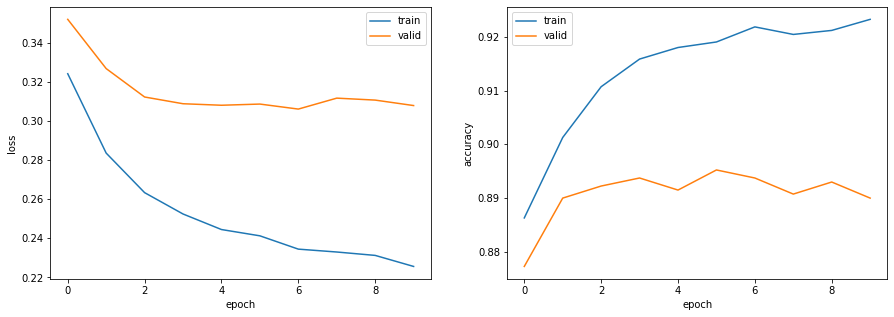

In [165]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(np.array(log_train).T[0],label="train")
ax[0].plot(np.array(log_valid).T[0],label="valid")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(np.array(log_train).T[1],label="train")
ax[1].plot(np.array(log_valid).T[1],label="valid")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()

### 76 チェックポイント
>>
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [166]:
model=SLPNet(300,4)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-1)
epochs=10
log_train,log_valid=[],[]
for epoch in range(1,epochs+1):
  model.train()
  for train,labels in dataloader_train:
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=criterion(outputs,labels)
    loss.backward()
    optimizer.step()
  loss_train,acc_train=calculate_accuracy_loss(model,dataloader_train,criterion)
  loss_valid,acc_valid=calculate_accuracy_loss(model,dataloader_valid,criterion)
  log_train.append([loss_train,acc_train])
  log_valid.append([loss_valid,acc_valid])
  torch.save({"epoch":epoch,"model_state_dict":model.state_dict,"optimizer_state_dict":optimizer.state_dict},f"checkpoint{epoch}.pt")
  print(f"epoch:{epoch},loss_train:{loss_train:.4f},acc_train:{acc_train:.4f},loss_valid:{loss_valid:.4f},acc_valid:{acc_valid:.4f}")


epoch:1,loss_train:1.8365,acc_train:0.2387,loss_valid:1.8346,acc_valid:0.2418
epoch:2,loss_train:1.9128,acc_train:0.2412,loss_valid:1.9099,acc_valid:0.2470
epoch:3,loss_train:1.8225,acc_train:0.2572,loss_valid:1.8200,acc_valid:0.2642
epoch:4,loss_train:1.8993,acc_train:0.2390,loss_valid:1.8969,acc_valid:0.2440
epoch:5,loss_train:1.8716,acc_train:0.2501,loss_valid:1.8688,acc_valid:0.2590
epoch:6,loss_train:1.7852,acc_train:0.2454,loss_valid:1.7837,acc_valid:0.2463
epoch:7,loss_train:1.8563,acc_train:0.2503,loss_valid:1.8534,acc_valid:0.2530
epoch:8,loss_train:1.7927,acc_train:0.2613,loss_valid:1.7901,acc_valid:0.2665
epoch:9,loss_train:1.8764,acc_train:0.2478,loss_valid:1.8737,acc_valid:0.2567
epoch:10,loss_train:1.8420,acc_train:0.2422,loss_valid:1.8397,acc_valid:0.2455


### 77 ミニバッチ化
>>
問題76のコードを改変し，B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．Bの値を1,2,4,8,…1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．

In [167]:
import time

In [168]:
def train_model_batch(dataset_train,dataset_valid,model,criterion,optimizer,batch_size):
  dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
  dataloader_valid=DataLoader(dataset_valid,batch_size=batch_size,shuffle=False)
  log_train,log_valid=[],[]
  epochs=1
  s_time=time.time()
  for epoch in range(1,epochs+1):
    model.train()
    for inputs,labels in dataloader_train:
      optimizer.zero_grad()
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
    loss_train,acc_train=calculate_accuracy_loss(model,dataloader_train,criterion)
    loss_valid,acc_valid=calculate_accuracy_loss(model,dataloader_valid,criterion)
    log_train.append([loss_train,acc_train])
    log_valid.append([loss_valid,acc_valid])
    torch.save({"epoch":epoch,"model_state_dict":model.state_dict,"optimizer_state_dict":optimizer.state_dict},f"checkpoint{epoch}.pt")
    e_time=time.time()
    print(f"epoch:{epoch},loss_train:{loss_train:.4f},acc_train:{acc_train:.4f},loss_valid:{loss_valid:.4f},acc_valid:{acc_valid:.4f},{e_time-s_time:.4f}sec")
  return {"train":log_train,"valid":log_valid}

  

In [169]:
dataset_train=NewDataset(X_train,y_train)
dataset_valid=NewDataset(X_valid,y_valid)
mdel=SLPNet(300,4)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-1)
for batch_size in [2**i for i in range(6)]:
  print(f"batch size:{batch_size}")
  log=train_model_batch(dataset_train,dataset_valid,model,criterion,optimizer,batch_size)

batch size:1
epoch:1,loss_train:0.3298,acc_train:0.8863,loss_valid:0.3470,acc_valid:0.8802,3.5385sec
batch size:2
epoch:1,loss_train:0.2988,acc_train:0.8986,loss_valid:0.3243,acc_valid:0.8892,1.9521sec
batch size:4
epoch:1,loss_train:0.2887,acc_train:0.9033,loss_valid:0.3186,acc_valid:0.8892,1.0140sec
batch size:8
epoch:1,loss_train:0.2855,acc_train:0.9047,loss_valid:0.3173,acc_valid:0.8892,0.5809sec
batch size:16
epoch:1,loss_train:0.2831,acc_train:0.9062,loss_valid:0.3203,acc_valid:0.8885,0.3423sec
batch size:32
epoch:1,loss_train:0.2822,acc_train:0.9062,loss_valid:0.3171,acc_valid:0.8892,0.2302sec


### 78 GPU上での学習
>>
問題77のコードを改変し，GPU上で学習を実行せよ．

In [170]:
def calculate_accuracy_loss_device(model,loader,criterion,device):
  loss,counts,total=0.0,0,0
  model.eval()
  with torch.no_grad():
    for inputs,labels in loader:
      inputs=inputs.to(device)
      labels=labels.to(device)
      outputs=model(inputs)
      loss+=criterion(outputs,labels).item()
      pred=torch.argmax(outputs,dim=-1)
      total+=len(inputs)
      counts+=(pred==labels).sum().item()
  return loss/len(loader),counts/total

In [171]:
def train_model_batch_device(dataset_train,dataset_valid,model,criterion,optimizer,batch_size,device=None):
  model.to(device)
  dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
  dataloader_valid=DataLoader(dataset_valid,batch_size=batch_size,shuffle=False)
  log_train,log_valid=[],[]
  epochs=1
  for epoch in range(1,epochs+1):
    s_time=time.time()
    model.train()
    for inputs,labels in dataloader_train:
      optimizer.zero_grad()
      inputs=inputs.to(device)
      labels=labels.to(device)
      optimizer.zero_grad()
      outputs=model.forward(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
    loss_train,acc_train=calculate_accuracy_loss_device(model,dataloader_train,criterion,device)
    loss_valid,acc_valid=calculate_accuracy_loss_device(model,dataloader_valid,criterion,device)
    log_train.append([loss_train,acc_train])
    log_valid.append([loss_valid,acc_valid])
    torch.save({"epoch":epoch,"model_state_dict":model.state_dict,"optimizer_state_dict":optimizer.state_dict},f"checkpoint{epoch}.pt")    
    e_time=time.time()
    print(f"epoch:{epoch},loss_train:{loss_train:.4f},acc_train:{acc_train:.4f},loss_valid:{loss_valid:.4f},acc_valid:{acc_valid:.4f},time:{e_time-s_time:.4f}sec")
  return {"train":log_train,"valid":log_valid}

  

In [172]:
dataset_train=NewDataset(X_train,y_train)
dataset_valid=NewDataset(X_valid,y_valid)
mdel=SLPNet(300,4)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-1)
device=torch.device("cuda")
for batch_size in [2**i for i in range(6)]:
  print(f"batch size:{batch_size}")
  log=train_model_batch_device(dataset_train,dataset_valid,model,criterion,optimizer,batch_size,device=device)

batch size:1
epoch:1,loss_train:0.2655,acc_train:0.9096,loss_valid:0.3116,acc_valid:0.8945,time:9.8141sec
batch size:2
epoch:1,loss_train:0.2592,acc_train:0.9174,loss_valid:0.3051,acc_valid:0.8967,time:4.8534sec
batch size:4
epoch:1,loss_train:0.2535,acc_train:0.9158,loss_valid:0.3027,acc_valid:0.8960,time:2.4562sec
batch size:8
epoch:1,loss_train:0.2520,acc_train:0.9164,loss_valid:0.3017,acc_valid:0.8930,time:1.2917sec
batch size:16
epoch:1,loss_train:0.2516,acc_train:0.9170,loss_valid:0.3062,acc_valid:0.8945,time:0.7113sec
batch size:32
epoch:1,loss_train:0.2512,acc_train:0.9171,loss_valid:0.3032,acc_valid:0.8937,time:0.3957sec


### 79 多層ニューラルネットワーク
>>
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [173]:
from torch.nn import functional as F

In [174]:
class MLPNet(nn.Module):
  def __init__(self,input_size,mid_size,output_size,mid_layers):
    super().__init__()
    self.mid_layers=mid_layers
    self.func_in=nn.Linear(input_size,mid_size)
    self.func_mid=nn.Linear(mid_size,mid_size)
    self.func_out=nn.Linear(mid_size,output_size)
    self.bn=nn.BatchNorm1d(mid_size)
  def forward(self,x):
    x=F.relu(self.func_in(x))
    for _ in range(self.mid_layers):
      x=F.relu(self.bn(self.func_mid(x)))
    x=F.relu(self.func_out(x))
    return x

In [175]:
def train_model_multi(dataset_train,dataset_valid,model,criterion,optimizer,batch_size,device):
  model.to(device)
  dataloader_train=DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
  dataloader_valid=DataLoader(dataset_valid,batch_size=batch_size,shuffle=False)
  log_train,log_valid=[],[]
  epochs=30
  scheduler=torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,epochs,eta_min=1e-5,last_epoch=-1)
  for epoch in range(1,epochs+1):
    s_time=time.time()
    model.train()
    for inputs,labels in dataloader_train:
      optimizer.zero_grad()
      inputs=inputs.to(device)
      labels=labels.to(device)
      outputs=model.forward(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
    loss_train,acc_train=calculate_accuracy_loss_device(model,dataloader_train,criterion,device)
    loss_valid,acc_valid=calculate_accuracy_loss_device(model,dataloader_valid,criterion,device)
    log_train.append([loss_train,acc_train])
    log_valid.append([loss_valid,acc_valid])
    torch.save({"epoch":epoch,"model_state_dict":model.state_dict,"optimizer_state_dict":optimizer.state_dict},f"checkpoint{epoch}.pt")
    e_time=time.time()
    print(f"epoch:{epoch},loss_train:{loss_train:.4f},acc_train:{acc_train:.4f},loss_valid:{loss_valid:.4f},acc_valid:{acc_valid:.4f},time:{e_time-s_time:.4f}sec")
    scheduler.step()
  return {"train":log_train,"valid":log_valid}

  

In [176]:
dataset_train=NewDataset(X_train,y_train)
dataset_valid=NewDataset(X_valid,y_valid)
model=MLPNet(300,200,4,1)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=1e-3)
device=torch.device("cuda")
log=train_model_multi(dataset_train,dataset_valid,model,criterion,optimizer,32,device)

epoch:1,loss_train:0.7402,acc_train:0.7722,loss_valid:0.7339,acc_valid:0.7717,time:0.6899sec
epoch:2,loss_train:0.5993,acc_train:0.7907,loss_valid:0.5968,acc_valid:0.7897,time:0.6824sec
epoch:3,loss_train:0.5213,acc_train:0.8192,loss_valid:0.5217,acc_valid:0.8159,time:0.6760sec
epoch:4,loss_train:0.4689,acc_train:0.8471,loss_valid:0.4727,acc_valid:0.8496,time:0.6649sec
epoch:5,loss_train:0.4297,acc_train:0.8668,loss_valid:0.4356,acc_valid:0.8675,time:0.6669sec
epoch:6,loss_train:0.3986,acc_train:0.8744,loss_valid:0.4076,acc_valid:0.8757,time:0.6799sec
epoch:7,loss_train:0.3748,acc_train:0.8852,loss_valid:0.3855,acc_valid:0.8847,time:0.6824sec
epoch:8,loss_train:0.3556,acc_train:0.8883,loss_valid:0.3693,acc_valid:0.8877,time:0.6718sec
epoch:9,loss_train:0.3431,acc_train:0.8932,loss_valid:0.3587,acc_valid:0.8915,time:0.7095sec
epoch:10,loss_train:0.3286,acc_train:0.8967,loss_valid:0.3463,acc_valid:0.8945,time:0.6792sec
epoch:11,loss_train:0.3206,acc_train:0.8990,loss_valid:0.3405,acc_val

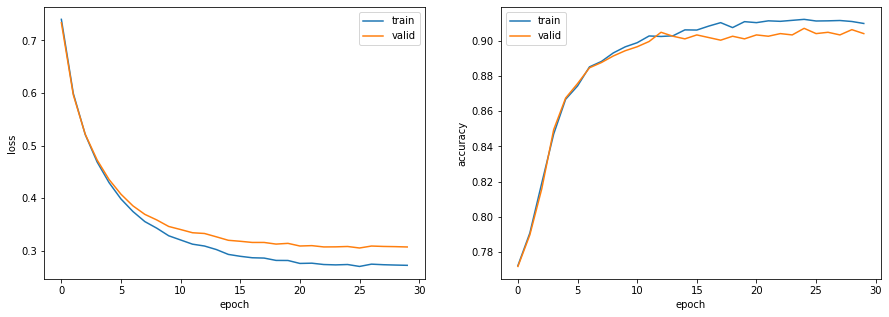

In [177]:
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0].plot(np.array(log["train"]).T[0],label="train")
ax[0].plot(np.array(log["valid"]).T[0],label="valid")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(np.array(log["train"]).T[1],label="train")
ax[1].plot(np.array(log["valid"]).T[1],label="valid")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()

In [178]:
def calculate_accuracy_device(model,loader,device):
  model.eval()
  total,counts=0,0
  with torch.no_grad():
    for inputs,labels in loader:
      inputs=inputs.to(device)
      labels=labels.to(device)
      outputs=model(inputs)
      pred=torch.argmax(outputs,dim=-1)
      total+=len(inputs)
      counts+=(pred==labels).sum().item()
  return counts/total

In [179]:
acc_train=calculate_accuracy_device(model,dataloader_train,device)
acc_test=calculate_accuracy_device(model,dataloader_test,device)
print(f"train accuracy:{acc_train:.3f}")
print(f"test accuracy:{acc_test:.3f}")

train accuracy:0.910
test accuracy:0.891
